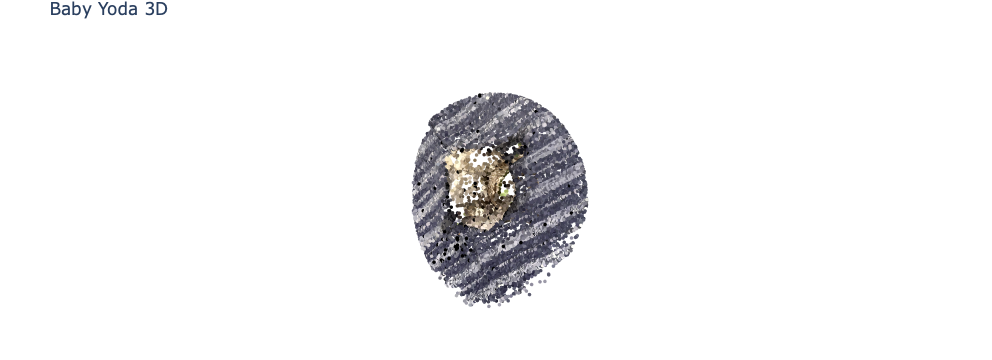

In [17]:
import open3d as o3d
import plotly.graph_objects as go
import numpy as np

def visualize_smart():
    # Загрузка
    pcd = o3d.io.read_point_cloud("yoda_v2.ply")
    
    # Фильтрация шума
    # Удаляем точки, у которых мало соседей в радиусе
    cl, ind = pcd.remove_statistical_outlier(nb_neighbors=10, std_ratio=0.9)
    pcd = pcd.select_by_index(ind)
    
    points = np.asarray(pcd.points)
    colors = np.asarray(pcd.colors)

    # Центрирование: находим медиану
    median_coords = np.median(points, axis=0)
    
    # Обрезаем всё, что слишком далеко от центра 
    distances = np.linalg.norm(points - median_coords, axis=1)
    max_dist = np.percentile(distances, 90) 
    
    mask = distances < max_dist
    points = points[mask]
    colors = colors[mask]

    # Визуализация
    fig = go.Figure(data=[go.Scatter3d(
        x=points[:, 0], y=points[:, 1], z=points[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color=colors,
            opacity=1.0
        )
    )])

    fig.update_layout(
        title="Baby Yoda 3D",
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            aspectmode='data'
        ),
        margin=dict(l=0, r=0, b=0, t=30)
    )
    fig.show()

if __name__ == "__main__":
    visualize_smart()

In [20]:
import open3d as o3d
import numpy as np

def generate_mvs_mesh():
    # Загрузка разреженного облака
    pcd = o3d.io.read_point_cloud("yoda_v2.ply")
    
    # Очистка от шума
    pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    
    # Оценка нормалей 
    # Это замена PatchMatch в COLMAP, потому что у меня нет cuda
    print("Оценка нормалей")
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    pcd.orient_normals_consistent_tangent_plane(k=15)

    # Создание сетки методом Alpha Shapes
    print("Генерация сетки (замена MVS)")
    alpha = 0.03 
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)
    
    # Сохранение в формате PLY
    print("Сохранение сетки в yoda_mesh.ply")
    o3d.io.write_triangle_mesh("yoda_mesh.ply", mesh)

if __name__ == "__main__":
    generate_mvs_mesh()

Оценка нормалей
Генерация сетки (замена MVS)
Сохранение сетки в yoda_mesh.ply
